<a href="https://colab.research.google.com/github/Beauremontt/AGN-Flux-Timing-Analysis/blob/main/AGNFluxTimingAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Initialization

## 1.1 Modules & Functions

In [25]:
# @title  { form-width: "30%" }

# whether or not to save all plotted figures to the current session
save_plots = True # @param {type:"boolean"}

# whether saved plots should have transparent instead of white backgrounds
transparent_plots = True # @param {type:"boolean"}



import numpy as np  # for math and arrays
import matplotlib.pyplot as plt  # for plotting

import requests  # for loading urls
from io import StringIO  # for passing text from url to numpy

from astropy.timeseries import LombScargle  # for the periodogram
from tabulate import tabulate  # for printing values of the LSP

from scipy.signal import find_peaks  # for intervals of peaks
from scipy.optimize import curve_fit  # for fitting the LSP to an exponential, and peaks to Gaussians


# function to save plot to file; assumes `save_plots == True`
  # pass `suffix` as a string to append to the filename
def save_plot(suffix):
  plt.savefig(fname=flux_source+" "+suffix, dpi=300, transparent=transparent_plots)


# function to plot light curve and print some preliminary info
  # doesn't include plt.show(), add after calling function and adding whatever elements
def display_data(prefix):

  plt.subplots(1, 1, figsize=(12, 8))
  plt.errorbar(x/86400, y, yerr=dy, fmt='_k', ecolor='c', elinewidth=1)

  plt.title(f'{prefix} light curve\n{flux_source}     {band_label}', fontsize=24)
  plt.xlabel('MJD', fontsize=20)
  plt.ylabel('Flux', fontsize=20)
  plt.tick_params(labelsize=18)

  if lc_xlim != None: plt.xlim(lc_xlim)
  if lc_ylim != None: plt.ylim(lc_ylim)

  print("\nNumber of data points =", NumData, "Start MJD =", x[0]/86400, "End MJD =", x[NumData - 1]/86400)
  print("Data Span =", Span/86400, "days",)
  print("Mean Spacing =", MeanSpacing/86400, "days\n")

## 1.2 Load data


Number of data points = 3329 Start MJD = 55064.5 End MJD = 60403.5
Data Span = 5339.0 days
Mean Spacing = 1.6037849203965153 days



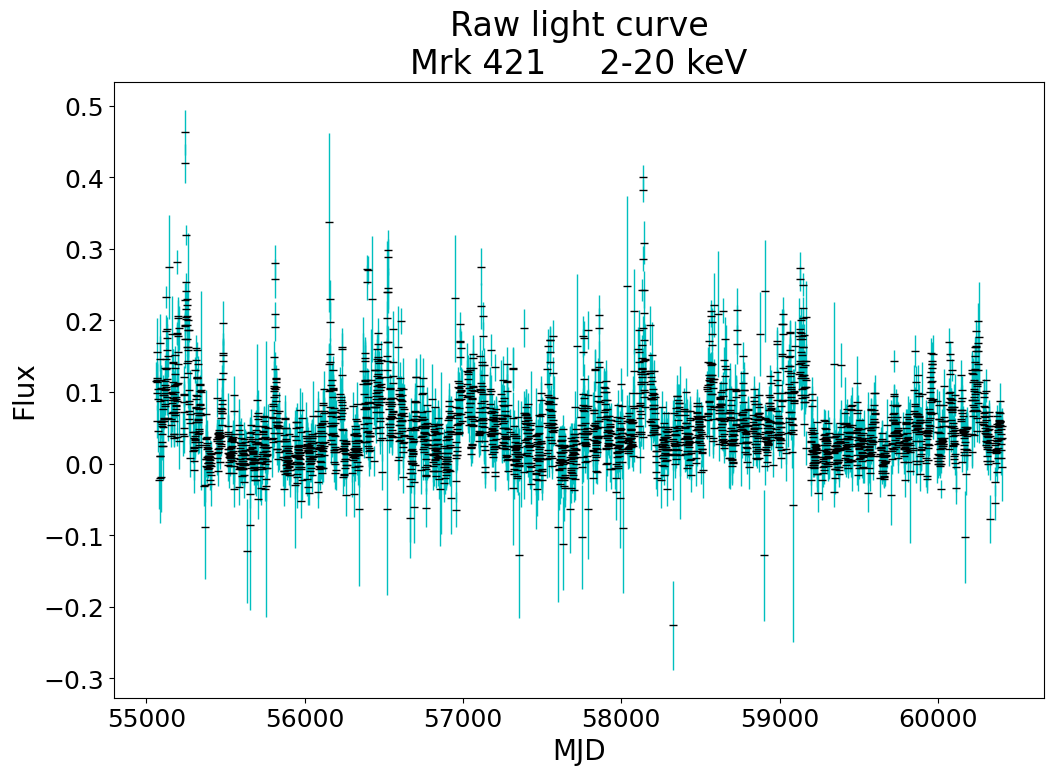

In [26]:
# @title  { form-width: "30%" }

# url of the flux data
url = "http://maxi.riken.jp/star_data/J1104+382/J1104+382_g_lc_1day_all.dat" # @param {type:"string"}

# filename if you choose not to pull from url
filename = "" # @param {type:"string"}

# name of the AGN to display on plots
flux_source = "Mrk 421"  # @param {type:"string"}

# which energy range to use; value is ordinal and depends on the archive
  # MAXI includes four different bands in each data file: 2-20, 2-4, 4-10, and 10-20 keV
energy_band = 1 # @param {type:"slider", min:1, max:4, step:1}
# the data column the chosen band corresponds to
flux_column = (energy_band-1)*2 + 1

# title of energy range of the flux measurements; prints below flux_source on plots
band_label = "2-20 keV"  # @param {type:"string"}

# number of lines to skip at the beginning of the file
  # `np.genfromtxt` automatically skips commented lines (rows beginning with '#')
skip_header = 0  # @param {type:"integer"}

# number of lines to skip at bottom
skip_footer = 0  # @param {type:"integer"}

# whether or not to print the unfiltered light curve
display_raw = True  # @param {type:"boolean"}


# choose txt_content from inputs; prioritizes urls
if url != "":
  # fetch the content from the url
  response = requests.get(url)

  # create a text file-like with the data
  txt_content = StringIO(response.text)
elif filename != "": txt_content = filename
else: raise Exception("No flux data.")



# create an array from the text file
AGN = np.genfromtxt(txt_content, skip_header = skip_header, skip_footer = skip_footer)


# set up the values
x = 86400*AGN[:, 0]  # first column of the data set (MJD midpoint of observation in seconds)
y = AGN[:, flux_column]  # column of the data set (flux)
dy = AGN[:, flux_column + 1]  # next column of the data set (the uncertainty)

# get timespan and spacing of data
NumData = len(x)
Span = x[NumData - 1] - x[0]
MeanSpacing = Span / NumData


# plot of light curve
if display_raw == True:

  # x,y limits on light curve, in the form "(lower, upper)"; leave blank or 'None' to not limit the graphs
  lc_xlim = None  # @param {type:"raw"}
  lc_ylim = None  # @param {type:"raw"}

  display_data("Raw")

  # save and print plot
  if save_plots == True: save_plot("lc_filtered")
  plt.show()

# 2 Data & Analysis

## 2.1 Filter data


Number of data points = 2695 Start MJD = 55064.5 End MJD = 60402.5
Data Span = 5338.0 days
Mean Spacing = 1.9807050092764378 days



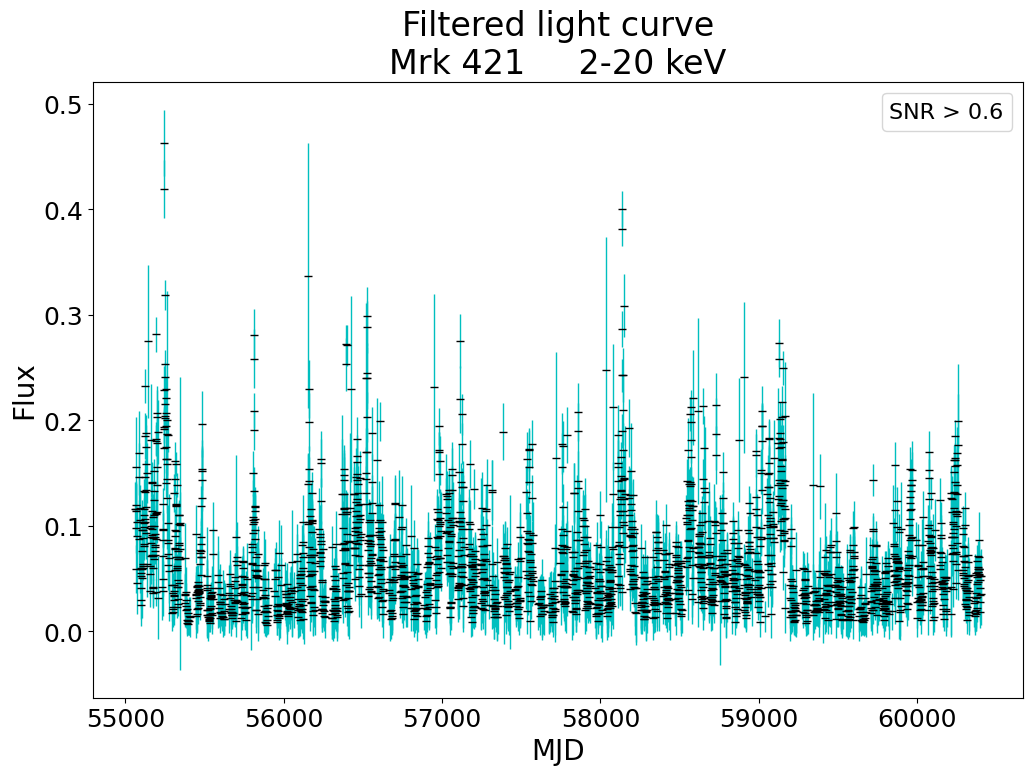

In [27]:
# @title  { form-width: "25%" }

# skips this cell if false
use_filter = True # @param {type:"boolean"}

# cut-off for filtering low S/N
SNR_tolerance = 0.6 # @param {type:"number"}



if use_filter == True:

  # reset values
  x = 86400*AGN[:, 0]  # MJD (s)
  y = AGN[:, flux_column]  # Flux
  dy = AGN[:, flux_column + 1]  # uncertainty


  # create array of signal-to-noise ratio
  SNR = y/dy

  # determine data points to filter
  rm = []  # array for points to remove
  for i in range(len(x)):
    if SNR[i] < SNR_tolerance:  # checks for low SNR (also negative y values)
      rm.append(i)

  # remove lines marked by filter
  x = np.delete(x, rm)
  y = np.delete(y, rm)
  dy = np.delete(dy, rm)


  # get timespan and spacing of data
  NumData = len(x)
  Span = x[NumData - 1] - x[0]
  MeanSpacing = Span / NumData


  # x,y limits on light curve, in the form "(lower, upper)"; leave blank or 'None' to not limit the graphs
  lc_xlim = None  # @param {type:"raw"}
  lc_ylim = None  # @param {type:"raw"}

  # print filtered light curve
  display_data("Filtered")

  # add filter information
  plt.scatter(x[0]/86400, y[0], s=0, label=f"SNR > {SNR_tolerance}")  # blank point for legend
  plt.legend(handletextpad=-0.1, handlelength=0, fontsize=16)  # legend just displays label

  # save and display plot
  if save_plots == True: save_plot("lc_filtered")
  plt.show()

## 2.2 Gap Histogram

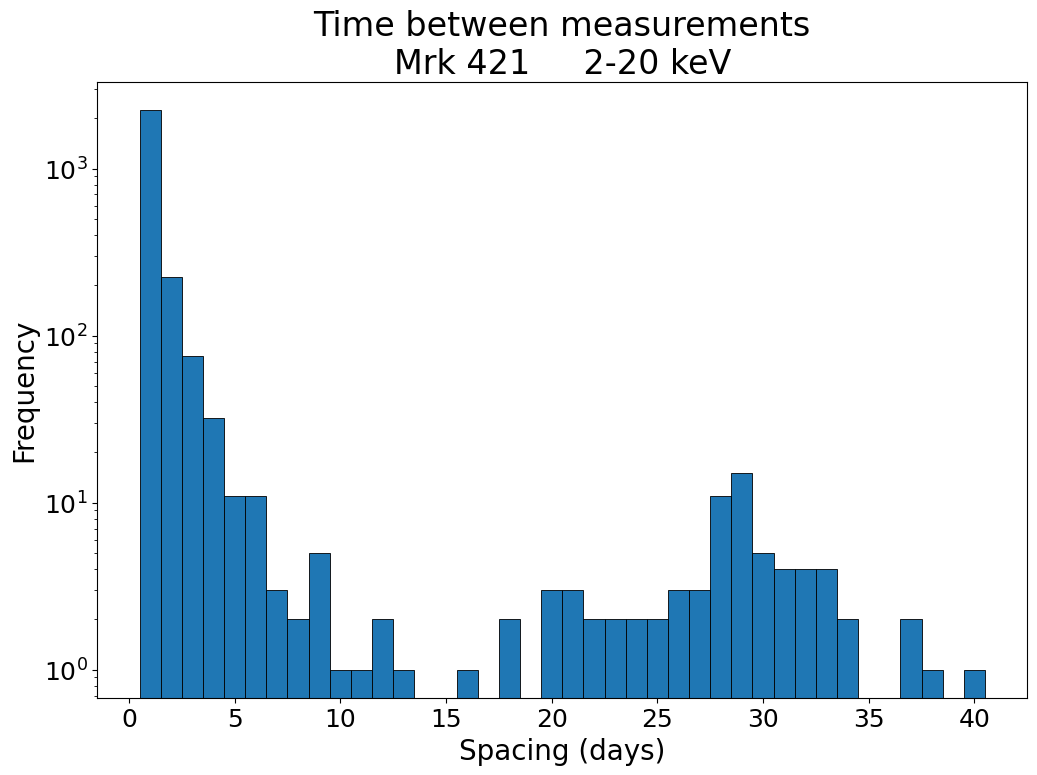


Mean Spacing = 1.9807050092764378 days


In [28]:
# @title  { form-width: "25%" }

# whether to plot the histogram in log or linear y-scale
hist_yscale = "log" # @param ["linear", "log"]


# get time gaps in days
delt_x = [(x[i] - x[i-1])/86400 for i in range(1, len(x))]

# make bins for day increments
max_gap = round(max(delt_x))
min_gap = round(min(delt_x))
bins = np.arange(min_gap, max_gap + 2) - 0.5


# plot histogram
plt.subplots(1,1,figsize=(12,8))
plt.hist(delt_x, bins=bins, align='mid', edgecolor='black', linewidth=25/len(bins))

# plot scaling
plt.yscale(hist_yscale)

# plot labels
plt.title(f'Time between measurements\n{flux_source}     {band_label}', fontsize=24)
plt.xlabel('Spacing (days)', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.tick_params(labelsize=18)

if save_plots == True: save_plot("gap_hist")
plt.show()
print("\nMean Spacing =", MeanSpacing/86400, "days")

## 2.3 Perform LSP and gather data

In [29]:
# @title  { form-width: "25%" }

# minimum_frequency, cuts off left of diagram
  # e.g., set to 2 to remove frequencies that would cover more than half the span
minif_factor = 2  # @param {type:"number"}

# nyquist_factor, multiple of the average nyquist frequency used to choose the maximum frequency
nyquist_factor = 1 # @param {type:"number"}



## PERFORM LSP
# data for the periodogram
ls = LombScargle(x, y, dy, normalization='standard')
frequency, power = ls.autopower(minimum_frequency = minif_factor/Span, nyquist_factor = nyquist_factor)
period = 1/(frequency*86400)  # converts frequencies (Hz) to periods (days)

# set up values for Thomas test
yy = 0 * x + 1  # Need to set the y values to one, in order to have the y axis be zero
dyy = 0 * x + 42
wls = LombScargle(x, yy, dyy)
ffrequency, ppower = wls.autopower(minimum_frequency = minif_factor/Span, nyquist_factor = nyquist_factor)
pperiod = 1/(frequency*86400)



### SIGNIFICANCE ANALYSIS
## Fit to exponential
# get log domain for fitted curve
log_min = np.log10(frequency[0])
log_max = np.log10(frequency[-1])
freq_exp = np.logspace(log_min, log_max, base=10)
period_exp = 1/(freq_exp*86400)

# exponential function to fit to
def exponential(x, a, b):
  return a * np.power(x, b)

# optimized parameters of fit for frequency
params, pcov = curve_fit(exponential, frequency, power)
prefactor, exponent = params  # parameters to fit curve
pre_err, exp_err = np.sqrt(np.diag(pcov))  # uncertainties in parameters

print("\n\nExponential fit: power = scaling prefactor * frequency^(scaling exponent)")
print(f"  scaling prefactor = {prefactor:.4}  +-  {pre_err:.4}")
print(f"  scaling exponent = {exponent:.4}  +-  {exp_err:.4}\n\n")

# plot to show linear fit in log scale
#plt.plot(freq_exp, exponential(freq_exp, prefactor, exponent))
#plt.yscale('log')
#plt.xscale('log')


## Calculate false alarm probabilities (FAP)
# get FAP for each power; values based on max power
  # FAP are upper limits (lower limits of significance) according to the Baluev method
FAP = ls.false_alarm_probability(power, method='baluev', minimum_frequency = minif_factor/Span, nyquist_factor = nyquist_factor)
FAP *= 100  # convert to percent units




Exponential fit: power = scaling prefactor * frequency^(scaling exponent)
  scaling prefactor = 2.431e-07  +-  3.056e-08
  scaling exponent = -0.6368  +-  0.007379




<ipython-input-29-9bcc6f2f8c24>:37: RuntimeWarning: overflow encountered in power
  return a * np.power(x, b)


## 2.4 Tabulate LSP Data

In [30]:
# @title  { form-width: "25%" }

# whether to fully print the table of periodogram data, before peaks are determined
  # this is the lengthiest process and should be left off
verbose_table = False # @param {type:"boolean"}


# find indices of extrema to get intervals of each peak
peaks, _ = find_peaks(power)  # returns indices of maxima
pits, _ = find_peaks(-power)  # use inverted power for indices of minima
n_peaks = len(peaks)  # count of how many peaks were found; will be the size of the table

# sort peaks by power and get their indices
sorted_peak_indices = peaks[np.argsort(power[peaks])[::-1]]


# pack the values of the LSP
lsp_data = [np.array(range(len(power))), power, frequency, period, FAP]  # combine arrays

# return data with only sorted peaks
sorted_data = [array[sorted_peak_indices] for array in lsp_data]


## print power-ordered table of just peaks
# convert to string
sorted_data_str = [array.astype(str) for array in sorted_data]

# insert headers
sorted_formatted_data = np.insert(sorted_data_str, 0, ["LSP index", "power", "frequency (Hz)", "period (days)", "FAP (%)"], 1)

# add a row to label each peak with its original index
sorted_peaks = [np.where(peaks == sorted_data[0][i])[0][0] for i in range(n_peaks)]
row_peak_num = ["peaks index"] + sorted_peaks  # create another row with a header

# insert new row of peaks into first place
sorted_formatted_data = np.vstack([row_peak_num, sorted_formatted_data])


# label the source
print("Source:", flux_source, "\nEnergy band:", band_label)


# print full frequency-ordered table (may take a few seconds)
if verbose_table == True:
  data_str = [array.astype(str) for array in lsp_data]  # convert data to string
  formatted_data = np.insert(data_str, 0, ["LSP index", "power", "frequency (Hz)", "period (days)", "FAP (%)"], 1)  # insert headers
  print("\nData as seen in power spectrum:\n")
  print(tabulate(formatted_data, numalign='left'), "\n")  # print as table

# print peaks-only, power-ordered table
print("\nPeaks in descending order of power:\n")
print(tabulate(sorted_formatted_data, numalign='left'))

Source: Mrk 421 
Energy band: 2-20 keV

Peaks in descending order of power:

--------------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  ----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  ----------  -----------  -----------  -----------  ----------- 

**Using the different indices:** \\
`sorted_peaks[i]` returns "peaks index" in order of descending power (as they appear in the table; `i` = column number in above table) \\
`peaks[i]` returns  "LSP index" for a given peak (`i` = number in row "peaks index"), which is the index used in the power and frequency arrays of the LSP \\
call any LSP value array by `LSP_array["LSP index"]`, where `LSP_array` is any of `power`, `frequency`, `period`
> indices are nested, so `frequency[peaks[sorted_peaks[0]]]` = frequency of highest peak (don't call values like this)


## 2.5 Power Spectrum

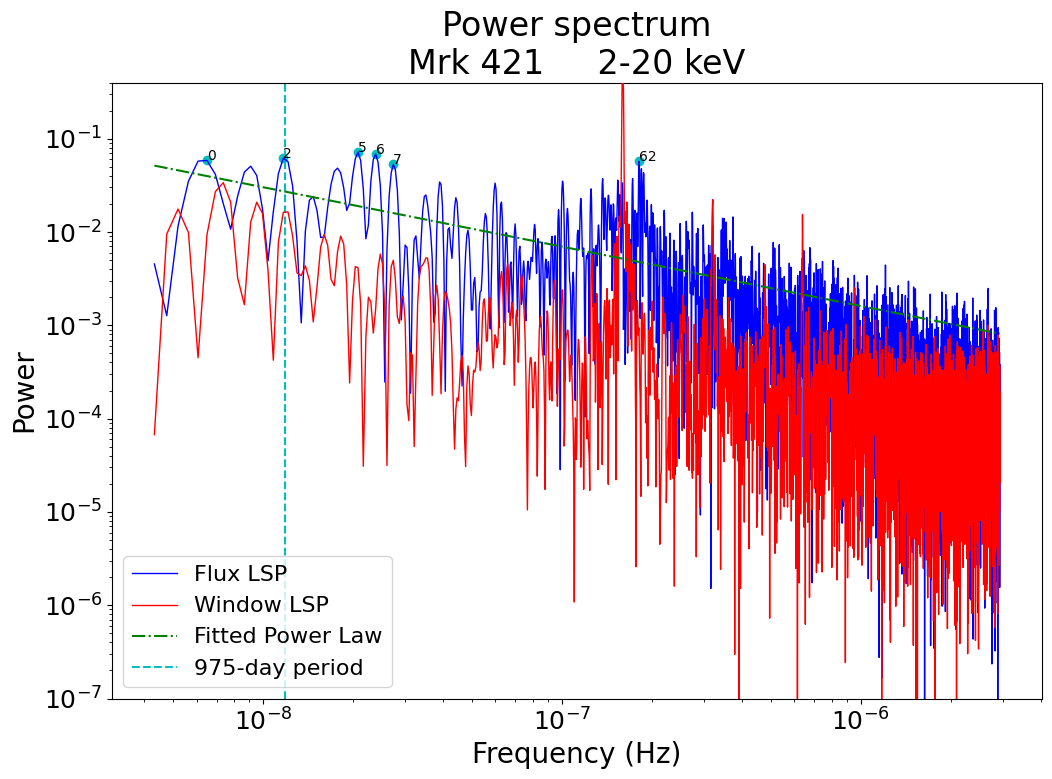

In [33]:
# @title  { form-width: "25%" }

# whether to plot the LSP in frequency or period space
lsp_xaxis = "Frequency (Hz)" # @param ["Frequency (Hz)", "Period (days)"]

# period in days to be plotted as a vertical line on the power spectrum
day_bar = 975 # @param {type:"raw"}

# how many of the top peaks to label; set to 0 to not label peaks
top_peaks = 6 # @param {type:"integer"}
if top_peaks == None: top_peaks = 0

# scaling of the power axis on the power spectrum: either log or linear
lsp_yscale = "log" # @param ["linear", "log"]

# whether to limit yscale to power min and slightly over power max
default_ylim = False # @param {type:"boolean"}

# give limits in the form "(lower, upper)", or leave blank
lsp_ylim = (10**-7, 4*10**-1)  # @param {type:"raw"}
lsp_xlim = None  # @param {type:"raw"}



# plot of power spectrum
plt.subplots(1,1,figsize=(12,8))
if lsp_xaxis == 'Frequency (Hz)':
  lsp_xs = frequency
  tht_xs = ffrequency
  fit_xs = freq_exp
else:
  lsp_xs = period
  tht_xs = pperiod
  fit_xs = period_exp
plt.plot(lsp_xs, power, 'b', linewidth=1, label='Flux LSP', zorder=2)  # actual LSP
plt.plot(tht_xs, ppower,'r', linewidth=1, label='Window LSP', zorder=3)  # Thomas test

# plot linear fit based on log-log plot
plt.plot(fit_xs, exponential(freq_exp, prefactor, exponent), 'g-.', label='Fitted Power Law', zorder=3)

# plot vertical line for scrubbing
if day_bar != 0 and day_bar != None:
  if lsp_xaxis == 'Period (days)':
    x_bar = day_bar
  else:
    x_bar = 1/(day_bar*86400)
  plt.axvline(x=x_bar, color='c', linestyle='dashed', label=f'{day_bar}-day period', zorder=1)


# plot notable peaks
if top_peaks > 0:
  high_peaks = sorted_peaks[:top_peaks]  # picks out indices of a number of higheast peaks
  idx_high = peaks[high_peaks]  # peaks indices to LSP indices
  plt.scatter(lsp_xs[idx_high], power[idx_high], color='c')  # places dots on graph
  for i in range(len(idx_high)):  # label dots with peaks index
    plt.text(lsp_xs[idx_high[i]], power[idx_high[i]], str(high_peaks[i]))

## manually choose plotted peaks and day-bars
#chosen_peaks = [5, 6, 2, 0, 62, 7, 1, 4, 46, 11, 17, 10, 3, 34]
#if len(chosen_peaks) > 0:
#  idx_high = peaks[chosen_peaks]
#  plt.scatter(lsp_xs[idx_high], power[idx_high], color='c')  # places dots on graph
#  for i in range(len(idx_high)):  # label dots with peaks index
#    plt.text(lsp_xs[idx_high[i]], power[idx_high[i]], str(chosen_peaks[i]))
#plt.axvline(x=1/(650*86400), linestyle='dashed', label=f'{650}-day period', zorder=1)
#plt.axvline(x=1/(325*86400), linestyle='dashed', label=f'{325}-day period', zorder=1)

# plot labels
plt.title(f'Power spectrum\n{flux_source}     {band_label}', fontsize=24)
plt.xlabel(lsp_xaxis, fontsize=20)
plt.ylabel('Power', fontsize=20)
plt.tick_params(labelsize=18)
plt.legend(fontsize=16)

# scaling of plot
plt.xscale('log')
plt.yscale(lsp_yscale)

# limits of plot
if default_ylim == True:
  lsp_ylim = (min(power), 1.1*max(power))
  if lsp_yscale == 'log':
    lsp_ylim = (0.9*min(power), 1.5*max(power))
if lsp_ylim != None: plt.ylim(lsp_ylim)

if lsp_xlim != None: plt.xlim(lsp_xlim)


# save figure to file
if lsp_xaxis == 'Frequency (Hz)':
  suffix = f" LSP (frequencies, {lsp_yscale})"
else:
  suffix = f" LSP (periods, {lsp_yscale})"
if save_plots == True: save_plot(suffix)

plt.show()

## 2.6 Choose a peak for analysis
Note: This error analysis assumes the peak is real, and makes no claim as to the certainty of the peak itself [VanderPlas, 2018]. See FAP for peak significances, which is printed below the graph for convenience. Also keep in mind that the FAP doesn't account for aliasing, and it likely isn't applied correctly anyway (AGNs may make red/pink noise, not white [Vaughan 2010]).

Lower bound: 14    Index at peak: 17    Upper bound: 21 



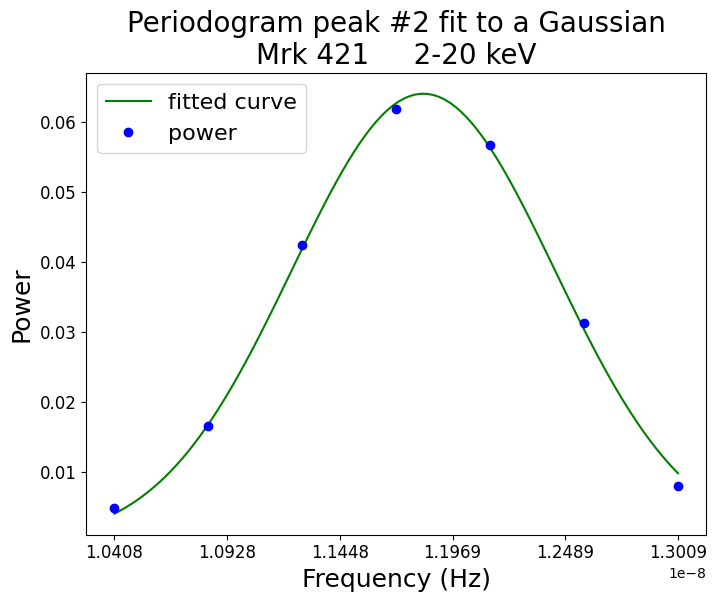


Peak power = 0.06403598778527035
FAP = 6.097750632694955e-32 

                Estimate    Uncertainty
--------------  ----------  ---------------------
frequency (Hz)  1.1834e-08  6.071883223038367e-10
period (days)   978.032     50.181434147859164
Percent                     5.13086 %






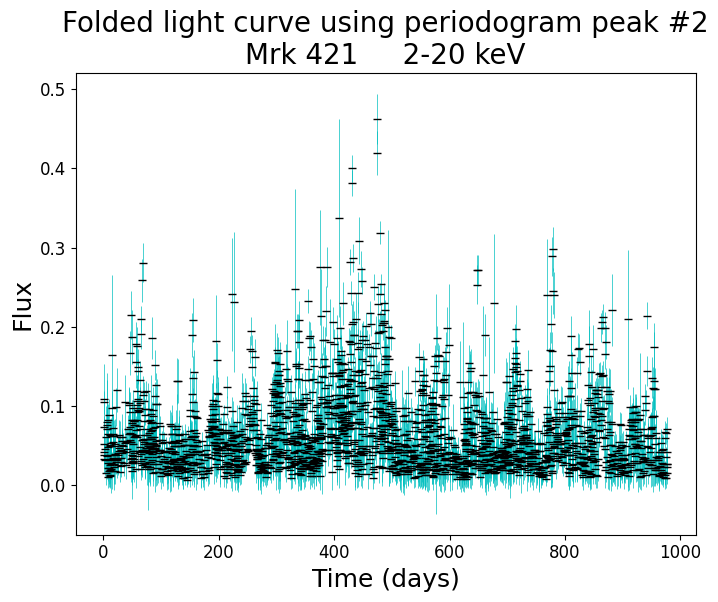

In [31]:
# @title  { form-width: "25%" }

# choose peak from labels on graph, or from 'peaks index' row of second table in 2.3
choose_peak = 2 # @param {type:"integer"}


# define interval around peak
interval_start = pits[choose_peak]
interval_end = pits[choose_peak+1]

# ensure the interval encloses the peak
if interval_start > peaks[choose_peak]:
  interval_start = pits[choose_peak-1]
  interval_end = pits[choose_peak]

print("Lower bound:", interval_start, "   Index at peak:", peaks[choose_peak], "   Upper bound:", interval_end, "\n")


# get data values
data_y = power[interval_start:interval_end]
data_x = frequency[interval_start:interval_end]

# define the Gaussian function
def Gauss(x, estimate_hz, uncertainty_hz, A):
   return A * np.exp(-(x - estimate_hz)**2 / (2 * uncertainty_hz**2))

# initial guess for parameters
init = [np.mean(data_x), np.std(data_x), np.max(data_y)]

# fit data to Gauss
params, covariance = curve_fit(Gauss, data_x, data_y, p0=init)

# get optimized parameters
estimate_hz, uncertainty_hz, amplitude = params

# convert parameters from seconds to days
percent_uncertainty = uncertainty_hz/estimate_hz
estimate_day = 1/(estimate_hz*86400)
uncertainty_day = percent_uncertainty * estimate_day


# plot fitted curve and data
plt.subplots(1,1,figsize=(8,6))
gauss_x = np.linspace(data_x[0], data_x[-1], 100)
plt.plot(gauss_x, Gauss(gauss_x, estimate_hz, uncertainty_hz, amplitude), 'g-', label="fitted curve")
plt.plot(data_x, data_y, 'bo', label="power")

# put labels on plot
plt.title(f"Periodogram peak #{choose_peak} fit to a Gaussian\n{flux_source}     {band_label}", fontsize=20)
plt.xticks(np.linspace(min(data_x), max(data_x), 6))
plt.xlabel("Frequency (Hz)", fontsize=18)
plt.ylabel("Power", fontsize=18)
plt.tick_params(labelsize=12)
plt.legend(fontsize=16)

# print results
if save_plots == True: save_plot("fit peak "+str(choose_peak))
plt.show()

print("\nPeak power =", amplitude)
print("FAP =", FAP[peaks[choose_peak]], "\n")
print(tabulate([["frequency (Hz)"] + [estimate_hz, uncertainty_hz],
                ["period (days)"] + [estimate_day, uncertainty_day],
                ["Percent", None, f"{percent_uncertainty*100:.5f} %"]],
                headers=["", "Estimate", "Uncertainty"], numalign='left'))


# plot folded light curve for chosen peak's estimated period
print("\n\n\n")
plt.subplots(1,1,figsize=(8,6))
#plt.scatter((x/86400)%estimate_day, y, s=2)
plt.errorbar((x/86400)%estimate_day, y, yerr=dy, fmt='_k', ecolor='c', elinewidth=0.5)


# plot fitted sinusoid for this period
...

# label folded light curve
plt.title(f"Folded light curve using periodogram peak #{choose_peak}\n{flux_source}     {band_label}", fontsize=20)
#plt.xticks(np.linspace(0, estimate_day, 6))
plt.xlabel("Time (days)", fontsize=18)
plt.ylabel("Flux", fontsize=18)
plt.tick_params(labelsize=12)
plt.show()

## 2.7 Some results

In [32]:
# @title

# This code cell is mostly a holdover from the original script.
# Most of the information printed can be found elsewhere.


# finds the maximum of the periodogram
imax = peaks[sorted_peaks[0]]
pdmax = period[imax]


## calculate False Alarm Probability [Horne & Baliunas, 1986]
# get number of independent frequencies, N_i
#N_0 = len(power)
#N_0 = NumData
#N_i = -6.392 + 1.193*NumData + 0.00098*NumData**2  # [H&B '86]
# pick out the highest peak
  # [H&B '86] "suppose that z is the highest peak in a periodogram" ... "probability that a peak of height z or hither will occur ... assuming pure noise"
#z = (np.max(power) - mu_tot)/sigma_tot  # [H&B '86] ??
#z = np.max(power)
# calculate "the probability that some peak is of height z or higher" [H&B '86]
#FAP = 1 - (1 - np.exp(-z)) ** N_i
#altFAP = 1 - (1 - np.exp(-z)) ** (NumData/2)


## print analysis results

print("\nNumber of data points =", NumData)  # part of 2.1
print("Start MJD =", x[0]/86400, "  End MJD =", x[NumData - 1]/86400)  # part of 2.1
print("Data Span =", Span/86400, "days",)  # part of 2.1
print("Mean Spacing =", MeanSpacing/86400, "days")  # part of 2.1 and 2.2


print("\nNumber of periodogram points =" , len(power))  # part of 2.3
print("Nyquist-limited frequencies =", NumData/2)  # is this correct? nyquist_factor is used in the LSP to affect this


print("\nMinimum  Power: ", np.min(power))  # part of 2.3
print("Maximum Power: ", np.max(power))  # part of 2.3
print("Index at max power = ", imax)  # part of 2.3

print("\nFrequency at Maximum Power =", frequency[imax], "Hz")  # part of 2.3
print("Period at Maximum Power =", pdmax, "days")  # part of 2.3
if pdmax < 3/24: print("                        =", pdmax*1440, "minutes")
elif pdmax < 2: print("                        =", pdmax*24, "hours")

print("\nMean power =", np.mean(power))
print("Power standard deviation =", np.std(power))
print("Power total variance =", np.std(power)**2)

#print("\nNumber of independent frequencies =", N_i)
#print("z =", z)
#print("False Alarm Probability of Max Power =", FAP)
#print("AltFAP (Nyquist) =", altFAP)


Number of data points = 2695
Start MJD = 55064.5   End MJD = 60402.5
Data Span = 5338.0 days
Mean Spacing = 1.9807050092764378 days

Number of periodogram points = 6729
Nyquist-limited frequencies = 1347.5

Minimum  Power:  1.232175267966145e-09
Maximum Power:  0.07199658932802598
Index at max power =  38

Frequency at Maximum Power = 2.0815120103242993e-08 Hz
Period at Maximum Power = 556.0416666666667 days

Mean power = 0.0016389941722758591
Power standard deviation = 0.004817141699726279
Power total variance = 2.3204854155241786e-05
